# Anomaly groups by proximity

In [21]:
import os
from os.path import join, dirname
import pandas as pd
import sys

ROOT = dirname(dirname(os.getcwd()))

SOURCE_CODE_PARENT = join(ROOT, "src")

DATA_PARENT = join(ROOT, "data")

sys.path.append(SOURCE_CODE_PARENT)

import math
import pandas as pd

from alerts import summarize

from alerts.preprocess import data2timeseries

In [22]:
def load_data(path_name: str) -> pd.DataFrame:
    data = pd.read_csv(f"{path_name}.csv", index_col=0)
    return data


def get_alerts(results):
    alerts_days = [
        day_results["date"]
        for day_results in results
        if not math.isnan(day_results["volume"])
    ]
    return alerts_days


def get_docs_per_day(data, alerts_day):
    texts_per_day = {
        day: summarize.select_texts_per_day(data, day) for day in alerts_day
    }
    return texts_per_day


def df_to_df_time_series(data: pd.DataFrame) -> pd.DataFrame:
    if "date" not in data.columns:
        data["date"] = data["created_at"].apply(lambda x: x[:10])
    df_ts = data2timeseries(data)
    return df_ts

In [23]:
name_data = "Sintomas_intestinales_uruguay_gender_sentiment"  #'congo_virus_data'#'immigration_data'#'diarrhea_vomit_data'#'20230921_Morocco_Health'#'20230922_Derechos LGTBIQ+'#'20230915_Morocco_Earthquake'#'Sintomas_intestinales_uruguay' '20230915_Morocco_Earthquake' 'Morocco_Earthquake''Libya_flood' 'Diarrhea+Vomit test' 'immigration-ie' 'Congo virus - Pakistan - Data (1)'
csv_file = join(DATA_PARENT, name_data)
data = load_data(csv_file)
data.head(3)

,Unnamed: 0,id,text,created_at,lang,source,name,screen_name,bio,us_created_at,...,country,country_code,locality,region,sub_region,coordinates,gender_pred,gender,text_pp,sentiment
0,0,1613402886142308353,"Me acabé de despertar con anciedad, lo único q...",2023-01-12T05:09:58+00:00,es,twitter,L✨,@letiigonzNo mNo mNo mNo matchtchtchtchleznumb...,22 años ❄️ ♍️ virgo,2015-07-17T22:46:12+00:00,...,Uruguay,UY,NaN,NaN,NaN,"-33.0, -56.0",2,Man,"Me acabé de despertar con anciedad, lo único q...",negative
1,1,1613399780641611776,Puedo decir que ya recuerdo xq odio fumar cogo...,2023-01-12T04:57:37+00:00,es,twitter,motomNo mNo mNo mNo mNo matchtchtchtchtchmi,@cNo mNo mNo mNo matchtchtchtchndusnumbersnumbers,ig : ponny_21_,2013-12-30T01:31:46+00:00,...,Uruguay,UY,Montevideo,Montevideo,NaN,"-34.83346, -56.16735",1,Woman,Puedo decir que ya recuerdo xq odio fumar cogo...,negative
2,2,1613378042029539328,"@soffi_avilaa q asco sofia, me dan nauseas lee...",2023-01-12T03:31:14+00:00,es,twitter,𝒇𝒍𝒐𝒓𝒆𝒏𝒄𝒊No mNo mNo mNo mNo matchtchtchtchtch,@flor_rosenberg,ig; floren_rosen07,2021-07-02T04:54:29+00:00,...,Uruguay,UY,NaN,Cerro Largo,NaN,"-32.33333, -54.33333",1,Woman,"q asco sofia, me dan nauseas leer tu tweet",negative


In [24]:
df_time_series = df_to_df_time_series(data)
df_time_series.head(3)

,date,timestamp,value
0,2023-01-01,1.672531e+09,36
1,2023-01-02,1.672618e+09,30
2,2023-01-03,1.672704e+09,29


---

## Punctual Outliers

In [25]:
from alerts.anomaly import AnomalyDetector
from alerts.time_series import AnomalyMeanTS
from alerts.dataclasses import TimeSeries

dates = df_time_series.date.values
values = df_time_series.value.values
ts = TimeSeries(dates, values)
mean_ts = AnomalyMeanTS(ts)

detector = AnomalyDetector()
anomaly_events = detector.detect_alerts(mean_ts)
anomaly_events

[Event(), Event(), Event(), Event(), Event(), Event(), Event(), Event()]

In [26]:
for anomaly in anomaly_events:
    print(anomaly.date, anomaly.value)

2023-02-06T00:00:00.000000000 54
2023-03-09T00:00:00.000000000 53
2023-03-26T00:00:00.000000000 52
2023-05-05T00:00:00.000000000 48
2023-05-08T00:00:00.000000000 49
2023-05-09T00:00:00.000000000 54
2023-05-10T00:00:00.000000000 62
2023-06-20T00:00:00.000000000 47


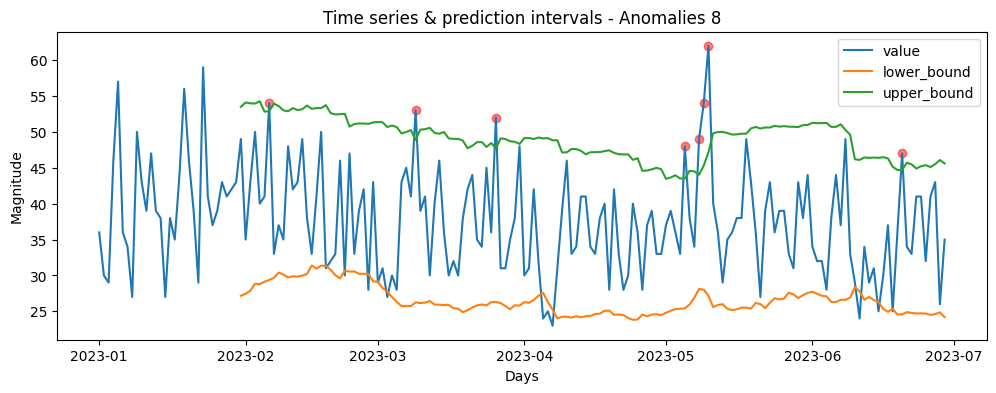

In [27]:
from alerts import plot

plot.plot(mean_ts, show_anomalies=True)

---

## Collective Outliers

In [28]:
from alerts.anomaly import AnomalyDetector
from alerts.time_series import AnomalyMeanTS
from alerts.dataclasses import TimeSeries

dates = df_time_series.date.values
values = df_time_series.value.values
ts = TimeSeries(dates, values)
mean_ts = AnomalyMeanTS(ts)
detector = AnomalyDetector()
groups = detector.detect_alerts_groups(mean_ts)

groups

[[Event()],
 [Event()],
 [Event()],
 [Event(), Event(), Event(), Event()],
 [Event()]]

In [29]:
for i, group in enumerate(groups, start=1):
    print(f"Group: {i}")
    print(10 * "***")
    for event in group:
        print(event.date, event.value)

Group: 1
******************************
2023-02-06T00:00:00.000000000 54
Group: 2
******************************
2023-03-09T00:00:00.000000000 53
Group: 3
******************************
2023-03-26T00:00:00.000000000 52
Group: 4
******************************
2023-05-05T00:00:00.000000000 48
2023-05-08T00:00:00.000000000 49
2023-05-09T00:00:00.000000000 54
2023-05-10T00:00:00.000000000 62
Group: 5
******************************
2023-06-20T00:00:00.000000000 47


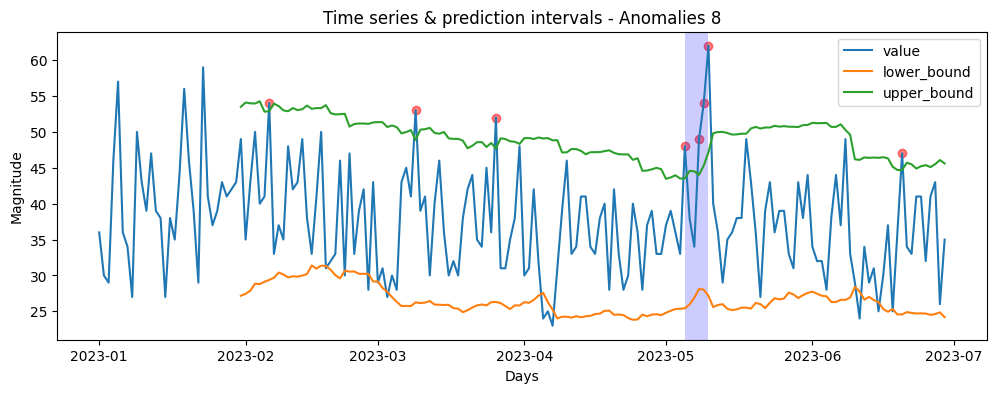

In [30]:
from alerts import plot
from alerts.time_series import AnomalyMeanTS
from alerts.dataclasses import TimeSeries

dates = df_time_series.date.values
values = df_time_series.value.values
ts = TimeSeries(dates, values)
mean_ts = AnomalyMeanTS(ts)

plot.plot_groups(mean_ts, show_anomalies=True)

---

## Segmentation

In [31]:
data.head(1)

,Unnamed: 0,id,text,created_at,lang,source,name,screen_name,bio,us_created_at,...,country_code,locality,region,sub_region,coordinates,gender_pred,gender,text_pp,sentiment,date
0,0,1613402886142308353,"Me acabé de despertar con anciedad, lo único q...",2023-01-12T05:09:58+00:00,es,twitter,L✨,@letiigonzNo mNo mNo mNo matchtchtchtchleznumb...,22 años ❄️ ♍️ virgo,2015-07-17T22:46:12+00:00,...,UY,NaN,NaN,NaN,"-33.0, -56.0",2,Man,"Me acabé de despertar con anciedad, lo único q...",negative,2023-01-12


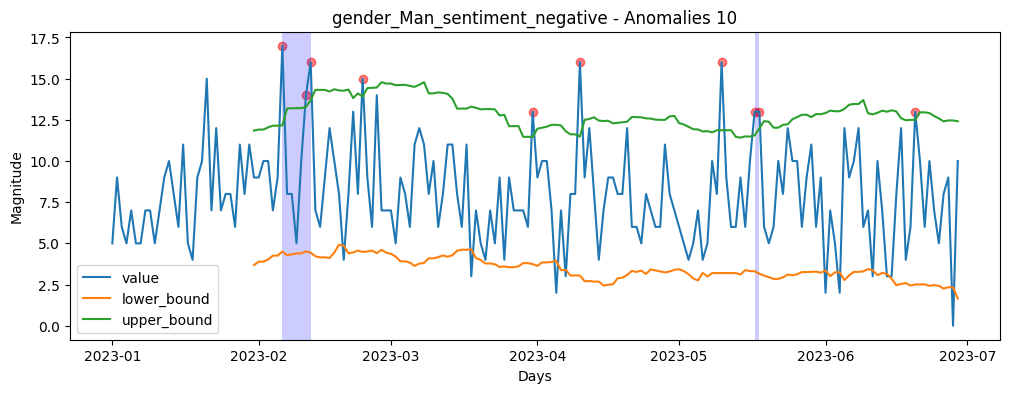

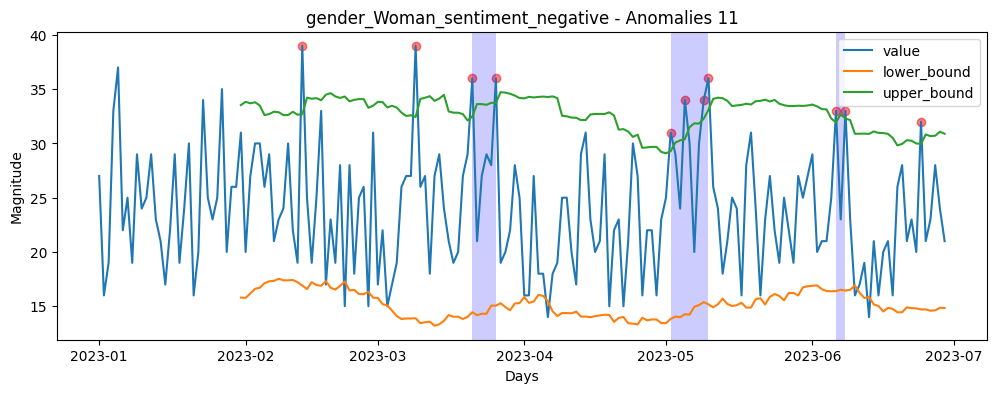

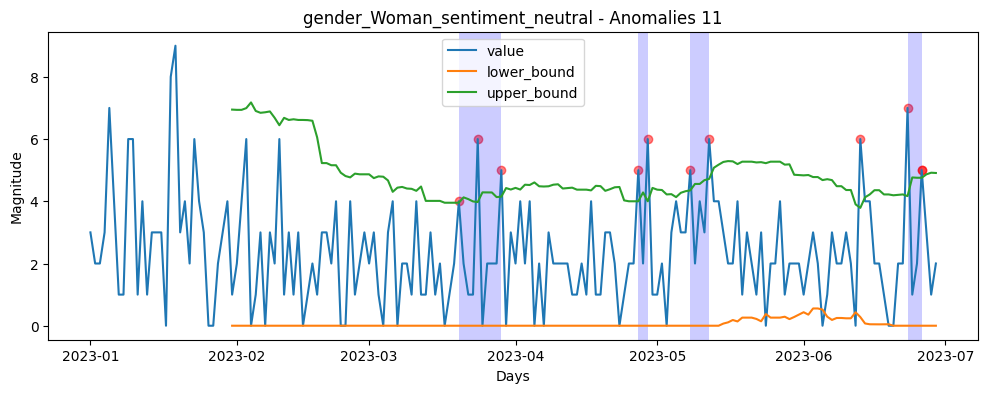

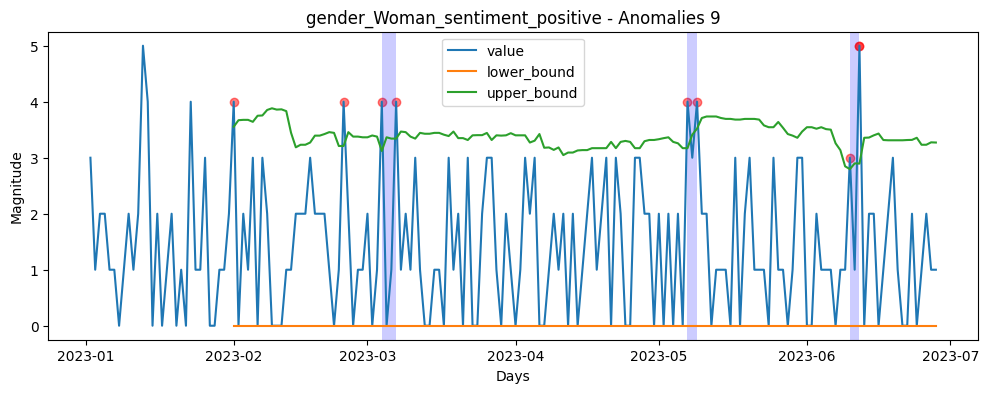

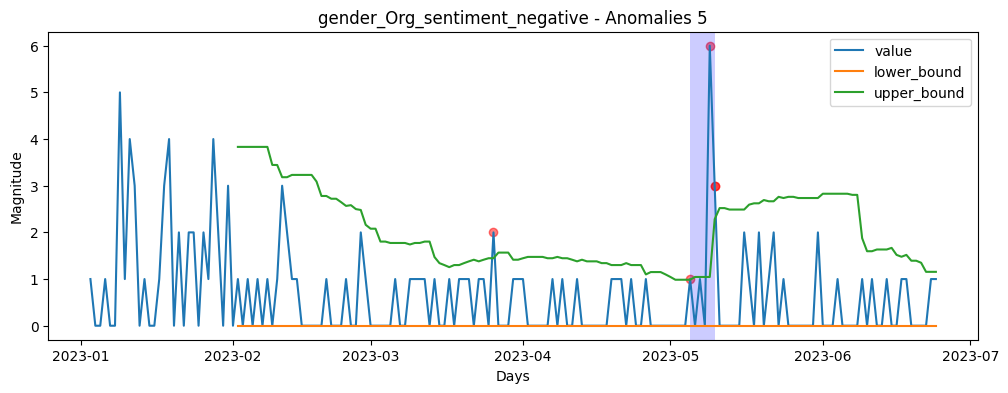

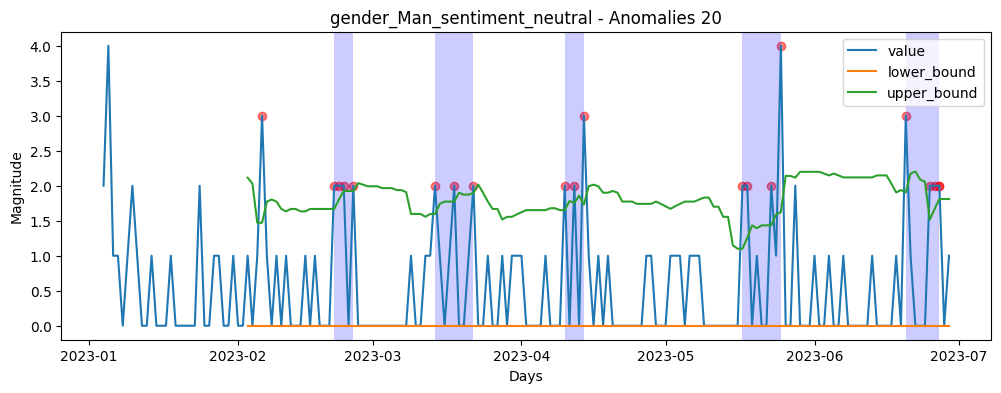

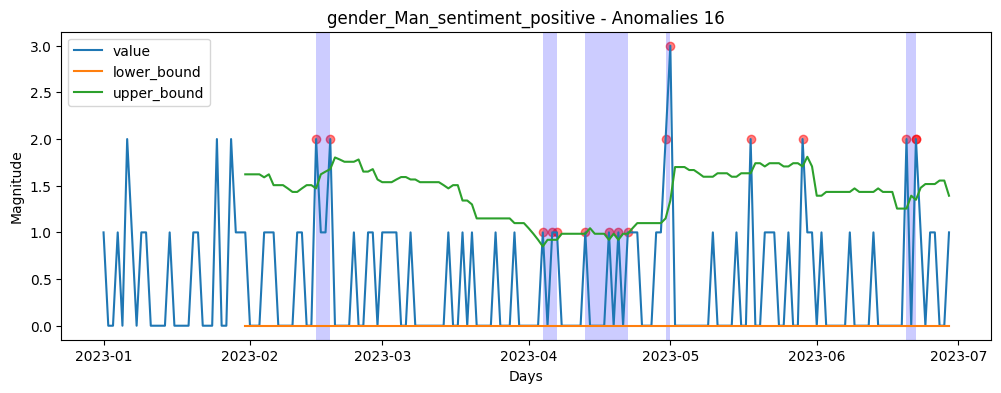

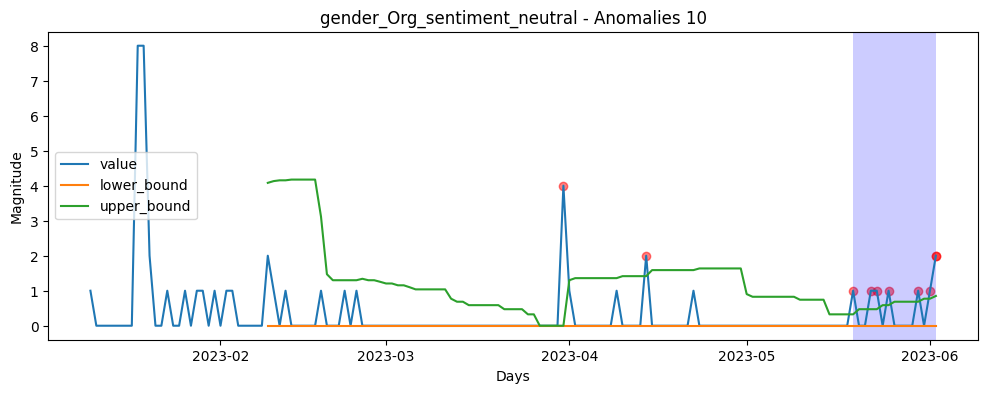

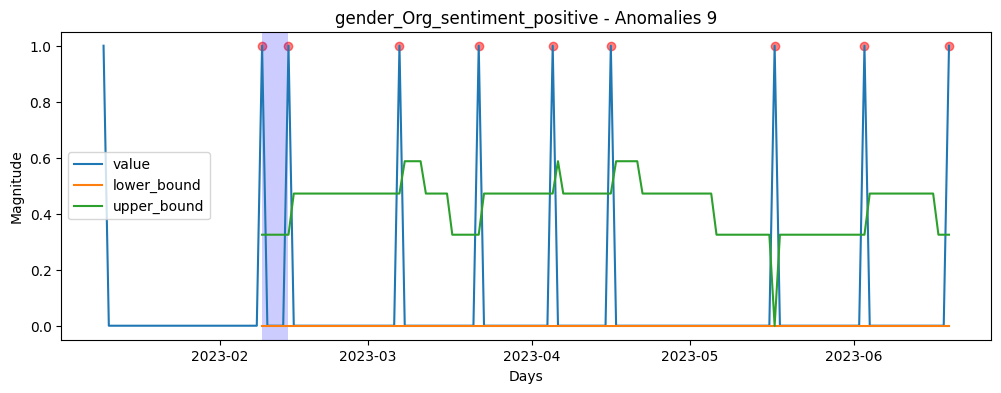

In [32]:
from alerts.utils import dataframe_segmentation
from alerts import plot
from alerts.time_series import AnomalyMeanTS
from alerts.dataclasses import TimeSeries

segmentation_by = ["gender", "sentiment"]
segments = dataframe_segmentation(data, segmentation_by)

for segment_id, segment in segments.items():
    df_time_series = df_to_df_time_series(segment)
    dates = df_time_series.date.values
    values = df_time_series.value.values
    ts = TimeSeries(dates, values)
    mean_ts = AnomalyMeanTS(ts)

    plot.plot_groups(mean_ts, show_anomalies=True, title=segment_id)